# Chapter7 课堂示例——Python卷积神经网络（图像）

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
# nn是神经网络的缩写
from torch import nn
from torch.utils import data
from torchsummary import summary

In [3]:
import warnings
warnings.filterwarnings('ignore')

## MNIST手写字数据集

### 设置设备

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cpu')

### 准备数据集

In [6]:
import torchvision
from torchvision import transforms

In [7]:
num_dataset_transform = transforms.Compose([
    transforms.ToTensor()
])

In [8]:
# 手写字数据集
train_num = torchvision.datasets.MNIST(root = './data', train = True, transform = num_dataset_transform, download = True)
test_num = torchvision.datasets.MNIST(root = './data', train = False, transform = num_dataset_transform, download = True)

In [9]:
len(train_num)

60000

In [10]:
len(test_num)

10000

In [11]:
# 图片的通道数是1,图片形状是28*28
train_num[0][0].shape

torch.Size([1, 28, 28])

In [12]:
# 输入变量的大小 1*28*28
insize = train_num[0][0].shape[0] * train_num[0][0].shape[1] * train_num[0][0].shape[2]
insize

784

In [13]:
# 输出变量的大小，一共10个数字，10类
outsize = len(train_num.classes)
outsize

10

### 展示查看图片

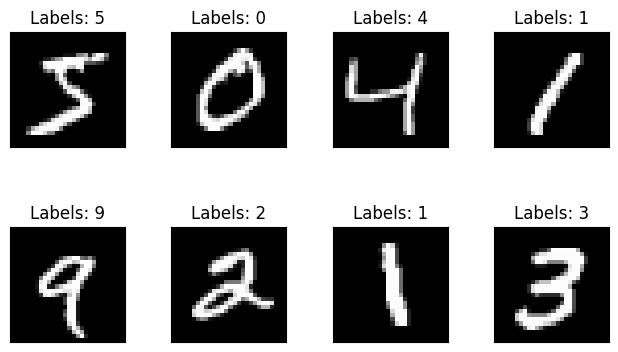

In [14]:
fig = plt.figure()
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.tight_layout()
    plt.imshow(train_num.train_data[i], cmap = 'gray', interpolation = 'none')
    plt.title('Labels: {}'.format(train_num.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

### 加载数据集

In [15]:
# 利用DataLoader来加载数据集
num_bs = 256
train_num_dataloader = data.DataLoader(dataset = train_num, batch_size = num_bs, shuffle = True, num_workers = 0, drop_last = True)
test_num_dataloader = data.DataLoader(dataset = test_num, batch_size = num_bs, shuffle = True, num_workers = 0, drop_last = True)

In [16]:
train_num_len = len(train_num_dataloader) * num_bs
test_num_len = len(test_num_dataloader) * num_bs
print(train_num_len)
print(test_num_len)

59904
9984


## 简单线性模型（Linear Regression）

### 搭建模型

In [17]:
class Linear(nn.Module):
    def __init__(self, input_size, output_size):
        super(Linear, self).__init__()
        self.linear = nn.Sequential(
            nn.Flatten(),   # 将28*28的二维矩阵展开成784的单维向量
            nn.Linear(in_features = input_size, out_features = output_size),  # 线性层
        )

    def forward(self, input):
        output = self.linear(input)
        return output

### 定义模型

In [18]:
linear = Linear(insize, outsize).to(device)

In [19]:
print(linear)

Linear(
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
  )
)


In [20]:
summary(linear, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


### 定义损失函数

In [21]:
linear_loss = nn.CrossEntropyLoss()   # 交叉熵

>**损失函数介绍<br>**<br>
>linear_loss = nn.CrossEntropyLoss()<br>
>linear_loss = linear_loss(outputs, targets)<br>
>注意以下几点：<br>
>outputs 是模型的输出分数，不需要先应用 softmax，因为 nn.CrossEntropyLoss 内部会处理。<br>
>targets 是真实标签索引，而不是 one-hot 编码。<br>
>nn.CrossEntropyLoss 会先对 outputs 应用 softmax，然后计算与 targets 之间的交叉熵损失<br>

### 定义优化器

In [22]:
linear_optimizer = torch.optim.SGD(linear.parameters(), lr = 0.01)   # 随机梯度下降算法

### 训练模型

In [23]:
%%time

epoch = 10  # 训练的轮数
linear_accuracy = []
for i in range(epoch):
    print("-------第 {} 轮训练-------".format(i + 1))
    
    # 训练
    linear.train()
    
    total_train_loss = 0
    total_train_accuracy = 0
    
    for X, y in train_num_dataloader:
        X = X.to(device)
        y = y.to(device)
        output = linear(X)
        
        l = linear_loss(output, y)
        total_train_loss = total_train_loss + l.item()
        
        linear_optimizer.zero_grad()   # 梯度清零
        l.backward()                   # 反向传播
        linear_optimizer.step()        # 优化
    
    print("整体训练集上的Loss: {}".format(total_train_loss))
    
    # 测试
    linear.eval()
    
    total_test_loss = 0
    total_test_accuracy = 0
    
    with torch.no_grad():
        for X, y in test_num_dataloader:
            X = X.to(device)
            y = y.to(device)
            output = linear(X)

            l = linear_loss(output, y)
            total_test_loss += l.item()

            accuracy = (output.argmax(1) == y).sum()
            total_test_accuracy += accuracy
    
    print("整体测试集上的Loss: {}".format(total_test_loss))
    print("整体测试集上的准确率: {}".format(total_test_accuracy / test_num_len))
    linear_accuracy.append(total_test_accuracy / test_num_len)

-------第 1 轮训练-------
整体训练集上的Loss: 366.28223741054535
整体测试集上的Loss: 43.013904333114624
整体测试集上的准确率: 0.8126001358032227
-------第 2 轮训练-------
整体训练集上的Loss: 222.71660125255585
整体测试集上的Loss: 31.324975907802582
整体测试集上的准确率: 0.8433493375778198
-------第 3 轮训练-------
整体训练集上的Loss: 177.26068550348282
整体测试集上的Loss: 26.328799545764923
整体测试集上的准确率: 0.8592748641967773
-------第 4 轮训练-------
整体训练集上的Loss: 154.8524421453476
整体测试集上的Loss: 23.538740694522858
整体测试集上的准确率: 0.8693910241127014
-------第 5 轮训练-------
整体训练集上的Loss: 141.14127057790756
整体测试集上的Loss: 21.68526580929756
整体测试集上的准确率: 0.8758012652397156
-------第 6 轮训练-------
整体训练集上的Loss: 131.79980963468552
整体测试集上的Loss: 20.397856563329697
整体测试集上的准确率: 0.8795071840286255
-------第 7 轮训练-------
整体训练集上的Loss: 124.91613611578941
整体测试集上的Loss: 19.38606485724449
整体测试集上的准确率: 0.881911039352417
-------第 8 轮训练-------
整体训练集上的Loss: 119.54786616563797
整体测试集上的Loss: 18.617347329854965
整体测试集上的准确率: 0.8852163553237915
-------第 9 轮训练-------
整体训练集上的Loss: 115.31749331951141
整体测试集上的Loss: 1

## 多层感知机（MLP）

### 搭建模型

In [24]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Flatten(),   # 将28*28的二维矩阵展开成784的单维向量
            nn.Linear(in_features = input_size, out_features = hidden_size),    # 线性层
            nn.ReLU(),                                                          # 激活函数
            nn.Linear(in_features = hidden_size, out_features = output_size),   # 线性层
        )

    def forward(self, input):
        output = self.mlp(input)
        return output

### 定义模型

In [25]:
hiddens = 128  # 隐藏层的维度
mlp = MLP(insize, hiddens, outsize).to(device)

In [26]:
print(mlp)

MLP(
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [27]:
summary(mlp, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


### 定义损失函数

In [28]:
mlp_loss = nn.CrossEntropyLoss()   # 交叉熵

### 定义优化器

In [ ]:
mlp_optimizer = torch.optim.SGD(mlp.parameters(), lr = 0.01)   # 随机梯度下降算法

### 训练模型

In [30]:
%%time

epoch = 10  # 训练的轮数
mlp_accuracy = []

for i in range(epoch):
    print("-------第 {} 轮训练 + 测试-------".format(i + 1))
    
    # 训练
    mlp.train()
    
    total_train_loss = 0
    total_train_accuracy = 0
    
    for X, y in train_num_dataloader:
        X = X.to(device)
        y = y.to(device)
        output = mlp(X)
        
        l = mlp_loss(output, y)
        total_train_loss = total_train_loss + l.item()
        
        mlp_optimizer.zero_grad()   # 梯度清零
        l.backward()                # 反向传播
        mlp_optimizer.step()        # 优化
    
    print("整体训练集上的Loss: {}".format(total_train_loss))
    
    # 测试
    mlp.eval()
    
    total_test_loss = 0
    total_test_accuracy = 0
    
    with torch.no_grad():
        for X, y in test_num_dataloader:
            X = X.to(device)
            y = y.to(device)
            output = mlp(X)

            l = mlp_loss(output, y)
            total_test_loss += l.item()

            accuracy = (output.argmax(1) == y).sum()
            total_test_accuracy += accuracy
    
    print("整体测试集上的Loss: {}".format(total_test_loss))
    print("整体测试集上的准确率: {}".format(total_test_accuracy / test_num_len))
    mlp_accuracy.append(total_test_accuracy / test_num_len)

-------第 1 轮训练 + 测试-------
整体训练集上的Loss: 481.9543647766113
整体测试集上的Loss: 67.29173243045807
整体测试集上的准确率: 0.7125400900840759
-------第 2 轮训练 + 测试-------
整体训练集上的Loss: 322.4235931634903
整体测试集上的Loss: 40.87729924917221
整体测试集上的准确率: 0.8114984035491943
-------第 3 轮训练 + 测试-------
整体训练集上的Loss: 209.33616119623184
整体测试集上的Loss: 28.758091151714325
整体测试集上的准确率: 0.8453525900840759
-------第 4 轮训练 + 测试-------
整体训练集上的Loss: 159.40494340658188
整体测试集上的Loss: 23.174821972846985
整体测试集上的准确率: 0.8640825152397156
-------第 5 轮训练 + 测试-------
整体训练集上的Loss: 134.19899025559425
整体测试集上的Loss: 20.071949005126953
整体测试集上的准确率: 0.8765023946762085
-------第 6 轮训练 + 测试-------
整体训练集上的Loss: 119.33362343907356
整体测试集上的Loss: 18.10901328921318
整体测试集上的准确率: 0.883713960647583
-------第 7 轮训练 + 测试-------
整体训练集上的Loss: 109.55683407187462
整体测试集上的Loss: 16.7746385037899
整体测试集上的准确率: 0.8894230723381042
-------第 8 轮训练 + 测试-------
整体训练集上的Loss: 102.60221666097641
整体测试集上的Loss: 15.810462862253189
整体测试集上的准确率: 0.8943309187889099
-------第 9 轮训练 + 测试-------
整体训练集

## 卷积神经网络（CNN）

### 搭建LeNet-5模型

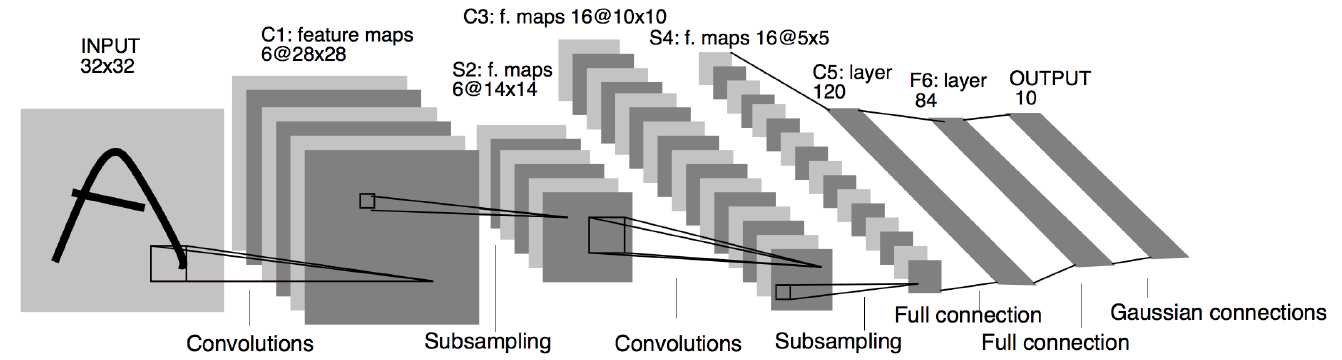

>**输入层 1@32×32（单通道28）<br>**
>（6个步幅为1填充为2的5×5卷积+Sigmoid激活）<br>
>**卷积层 6@28×28<br>**
>（2×2步幅为2的平均池化）<br>
>**池化层 6@14×14**<br>
>（16个步幅为1填充为1的5×5卷积+Sigmoid激活）<br>
>**卷积层 16@10×10<br>**
>（2×2步幅为2的平均池化）<br>
>**池化层 16@5×5<br>**
>（降维）<br>
>**降维 16×5×5 = 400<br>**
>（线性+Sigmoid激活）<br>
>**全连接层 120<br>**
>（线性+Sigmoid激活）<br>
>**全连接层 84<br>**
>（线性）<br>
>**输出层 10<br>**

In [31]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 5, stride = 1, padding = 2),    # 卷积层
            nn.Sigmoid(),                                                                              # 激活函数
            nn.AvgPool2d(kernel_size = 2, stride = 2),                                                 # 平均池化
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 5, stride = 1, padding = 0),   # 卷积层
            nn.Sigmoid(),                                                                              # 激活函数
            nn.AvgPool2d(kernel_size = 2, stride = 2),                                                 # 平均池化
            nn.Flatten(),                                                                              # 二维数据展平
            nn.Linear(in_features = 16 * 5 * 5, out_features = 120),                                   # 线性层
            nn.Sigmoid(),                                                                              # 激活函数
            nn.Linear(in_features = 120, out_features = 84),                                           # 线性层
            nn.Sigmoid(),                                                                              # 激活函数
            nn.Linear(in_features = 84, out_features = 10)                                             # 线性层
        )

    def forward(self, input):
        output = self.cnn(input)
        return output

### 定义模型

In [32]:
cnn = CNN().to(device)

In [33]:
print(cnn)

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): Sigmoid()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [34]:
summary(cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

### 定义损失函数

In [35]:
cnn_loss = nn.CrossEntropyLoss()   # 交叉熵

### 定义优化器

In [36]:
cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr = 0.01)   # Adam算法

### 训练模型

In [37]:
%%time

epoch = 10  # 训练的轮数
cnn_accuracy = []

for i in range(epoch):
    print("-------第 {} 轮训练 + 测试-------".format(i + 1))
    
    # 训练
    cnn.train()
    
    total_train_loss = 0
    total_train_accuracy = 0
    
    for X, y in train_num_dataloader:
        X = X.to(device)
        y = y.to(device)
        output = cnn(X)
        
        l = cnn_loss(output, y)
        total_train_loss = total_train_loss + l.item()
        
        cnn_optimizer.zero_grad()   # 梯度清零
        l.backward()                # 反向传播
        cnn_optimizer.step()        # 优化
    
    print("整体训练集上的Loss: {}".format(total_train_loss))
    
    # 测试
    cnn.eval()
    
    total_test_loss = 0
    total_test_accuracy = 0
    
    with torch.no_grad():
        for X, y in test_num_dataloader:
            X = X.to(device)
            y = y.to(device)
            output = cnn(X)

            l = cnn_loss(output, y)
            total_test_loss += l.item()

            accuracy = (output.argmax(1) == y).sum()
            total_test_accuracy += accuracy
    
    print("整体测试集上的Loss: {}".format(total_test_loss))
    print("整体测试集上的准确率: {}".format(total_test_accuracy / test_num_len))
    cnn_accuracy.append(total_test_accuracy / test_num_len)

-------第 1 轮训练 + 测试-------
整体训练集上的Loss: 539.265064239502
整体测试集上的Loss: 89.75779914855957
整体测试集上的准确率: 0.11358173191547394
-------第 2 轮训练 + 测试-------
整体训练集上的Loss: 531.445179104805
整体测试集上的Loss: 74.98853135108948
整体测试集上的准确率: 0.30178284645080566
-------第 3 轮训练 + 测试-------
整体训练集上的Loss: 148.62567806243896
整体测试集上的Loss: 6.880427822470665
整体测试集上的准确率: 0.9424078464508057
-------第 4 轮训练 + 测试-------
整体训练集上的Loss: 30.529594022780657
整体测试集上的Loss: 4.269370045512915
整体测试集上的准确率: 0.9652444124221802
-------第 5 轮训练 + 测试-------
整体训练集上的Loss: 20.602267876267433
整体测试集上的Loss: 3.056522198021412
整体测试集上的准确率: 0.9752604365348816
-------第 6 轮训练 + 测试-------
整体训练集上的Loss: 16.552915597334504
整体测试集上的Loss: 3.450504057109356
整体测试集上的准确率: 0.97265625
-------第 7 轮训练 + 测试-------
整体训练集上的Loss: 14.223142239265144
整体测试集上的Loss: 2.426508747972548
整体测试集上的准确率: 0.9807692170143127
-------第 8 轮训练 + 测试-------
整体训练集上的Loss: 11.603702316060662
整体测试集上的Loss: 2.112515293993056
整体测试集上的准确率: 0.9841746687889099
-------第 9 轮训练 + 测试-------
整体训练集上的Loss: 10

## 模型比较

In [38]:
x = list(range(1, 11))
x

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

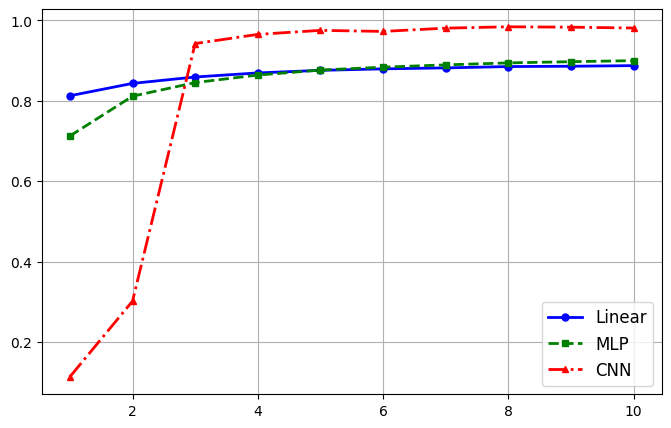

In [39]:
plt.figure(figsize = (8, 5))

# 绘制linear_accuracy
plt.plot(x, linear_accuracy, label = 'Linear', color = 'b', linewidth = 2, linestyle = '-', marker = 'o', markersize = 5)

# 绘制mlp_accuracy
plt.plot(x, mlp_accuracy, label = 'MLP', color = 'g', linewidth = 2, linestyle = '--', marker = 's', markersize = 5)

# 绘制cnn_accuracy
plt.plot(x, cnn_accuracy, label = 'CNN', color = 'r', linewidth = 2, linestyle = '-.', marker = '^', markersize = 5)

# 添加网格
plt.grid(True)

# 添加图例
plt.legend(loc = 'best', fontsize = 12)

# 显示图形
plt.show()

## 模型保存

In [40]:
torch.save(cnn.state_dict(), './models/cnn_number.pth')

# 课堂练习